In [31]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [32]:
!pip install rasterio

Defaulting to user installation because normal site-packages is not writeable


In [33]:
import os
import numpy as np
import rasterio
from tensorflow.keras.utils import to_categorical
from skimage.io import imread

# Define paths to images and labels
image_dir = 'data/images'
label_dir = 'data/labels/'

# Load image and label filenames
image_filenames = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.tif')])
label_filenames = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith('.png')])

def load_multispectral_image(image_path):
    with rasterio.open(image_path) as src:
        image = src.read()  # Load all 12 bands
    return image.transpose(1, 2, 0)  # Change to (height, width, channels)

def load_label(label_path):
    label = imread(label_path)
    label = (label > 0).astype(np.uint8)  # Ensure binary mask (0 or 1)
    return label

# Load all images and labels into arrays
images = np.array([load_multispectral_image(f) for f in image_filenames])
labels = np.array([load_label(f) for f in label_filenames])

# Convert labels to one-hot encoding
labels = np.expand_dims(labels, axis=-1)  # Add channel dimension
labels = to_categorical(labels, num_classes=2)  # Binary mask (0 for non-water, 1 for water)

print(f'Loaded {len(images)} images and {len(labels)} labels.')


Loaded 306 images and 456 labels.


In [34]:
# Normalizing images to [0, 1] range
def normalize_images(images):
    images_norm = np.zeros_like(images, dtype=np.float32)
    for i in range(images.shape[-1]):
        min_val = np.min(images[..., i])
        max_val = np.max(images[..., i])
        images_norm[..., i] = (images[..., i] - min_val) / (max_val - min_val)
    return images_norm

# Apply normalization to the dataset
images_normalized = normalize_images(images)

print("Images normalized.")


Images normalized.


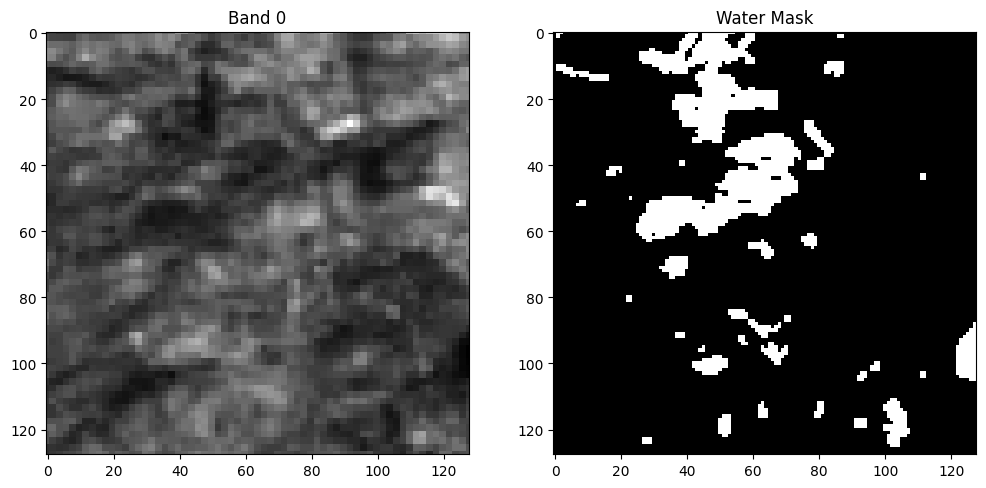

In [35]:
import matplotlib.pyplot as plt

# Function to visualize an image band and label
def visualize_sample(image, label, band_idx=0):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image[..., band_idx], cmap='gray')
    ax[0].set_title(f'Band {band_idx}')
    ax[1].imshow(label[..., 1], cmap='gray')  # Visualize water class
    ax[1].set_title('Water Mask')
    plt.show()

# Visualize the first sample
visualize_sample(images_normalized[0], labels[0], band_idx=0)


In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy

def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred):
    return categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def unet_with_pretrained_encoder(input_shape):
    inputs = Input(input_shape)

    # Pretrained ResNet50 as Encoder
    resnet = ResNet50(include_top=False, weights=None, input_tensor=inputs) # Remove weights='imagenet' to randomly initialize weights

    # Decoder
    c1 = resnet.get_layer('conv4_block6_2_relu').output  # 8x8x1024
    u2 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c1)  # 16x16x512
    u2 = concatenate([u2, resnet.get_layer('conv3_block4_2_relu').output])  # Skip connection
    c2 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(u2)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.3)(c2)

    u1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c2)  # 32x32x256
    u1 = concatenate([u1, resnet.get_layer('conv2_block3_2_relu').output])  # Skip connection
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(u1)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.3)(c3)

    u0 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c3)  # 64x64x128
    u0 = concatenate([u0, resnet.get_layer('conv1_relu').output])  # Skip connection
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(u0)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.3)(c4)

    # Final Upsampling
    u_final = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)  # 128x128x64
    c_final = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001))(u_final)
    c_final = BatchNormalization()(c_final)

    outputs = Conv2D(2, (1, 1), activation='softmax')(c_final)  #

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape as (128, 128, 12)
input_shape = (128, 128, 12)
model = unet_with_pretrained_encoder(input_shape)

# Compile the model with combined Dice + Categorical Crossentropy Loss and Focal Loss
model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy'])

# Show model summary
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)    │ (None, 128, 128, 12)      │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 134, 134, 12)      │               0 │ input_layer_4[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 64, 64, 64)        │          37,696 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 64, 64, 64)        │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 64, 64, 64)        │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 66, 66, 64)        │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 32, 32, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 32, 32, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 32, 32, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 32, 32, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 32, 32, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 32, 32, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 13,512,898 (51.55 MB)

 Trainable params: 13,482,434 (51.43 MB)

 Non-trainable params: 30,464 (119.00 KB)

In [45]:
# List all image and label filenames
image_filenames = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
label_filenames = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

# Print the lengths of both sets
print(f'Number of images: {len(image_filenames)}')
print(f'Number of labels: {len(label_filenames)}')

# Compare the filenames to find any mismatches
missing_images = [label for label in label_filenames if label.replace('.png', '.tif') not in image_filenames]
missing_labels = [image for image in image_filenames if image.replace('.tif', '.png') not in label_filenames]

print(f'Missing corresponding images for labels: {missing_images}')
print(f'Missing corresponding labels for images: {missing_labels}')


Number of images: 306
Number of labels: 456
Missing corresponding images for labels: ['100_184.png', '101_89.png', '102_179.png', '103_225.png', '104_20.png', '105_148.png', '106_267.png', '107_59.png', '108_236.png', '109_223.png', '10_244.png', '110_287.png', '111_121.png', '112_78.png', '113_44.png', '114_220.png', '115_49.png', '116_250.png', '117_97.png', '118_125.png', '119_222.png', '11_116.png', '120_305.png', '121_142.png', '122_257.png', '123_145.png', '124_95.png', '125_201.png', '126_110.png', '127_54.png', '128_294.png', '129_177.png', '12_286.png', '130_256.png', '131_185.png', '132_126.png', '133_224.png', '134_153.png', '135_56.png', '136_301.png', '137_140.png', '138_39.png', '139_108.png', '13_234.png', '140_34.png', '141_237.png', '142_238.png', '143_183.png', '144_235.png', '145_164.png', '146_84.png', '147_213.png', '148_297.png', '149_166.png', '14_135.png', '150_243.png', '15_233.png', '16_229.png', '17_60.png', '18_42.png', '19_293.png', '1_226.png', '20_283.png

In [46]:
# Remove labels that don't have corresponding images
valid_labels = [label for label in label_filenames if label.replace('.png', '.tif') in image_filenames]
valid_images = [image for image in image_filenames if image.replace('.tif', '.png') in label_filenames]

# Print the final counts to ensure they match
print(f'Final number of images: {len(valid_images)}')
print(f'Final number of labels: {len(valid_labels)}')


Final number of images: 306
Final number of labels: 306


In [47]:
# Reload the matched images and labels
valid_image_paths = [os.path.join(image_dir, f) for f in valid_images]
valid_label_paths = [os.path.join(label_dir, f) for f in valid_labels]

# Load all images and labels into arrays again
images = np.array([load_multispectral_image(f) for f in valid_image_paths])
labels = np.array([load_label(f) for f in valid_label_paths])

# Ensure labels are one-hot encoded
labels = np.expand_dims(labels, axis=-1)
labels = to_categorical(labels, num_classes=2)

print(f'Loaded {len(images)} images and {len(labels)} labels after filtering.')


C:\Users\Dell\AppData\Roaming\Python\Python311\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Loaded 306 images and 306 labels after filtering.


Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.8869 - io_u_1: 0.2769 - loss: 1.2920 - val_accuracy: 0.9144 - val_io_u_1: 0.2561 - val_loss: 1.1751
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.8982 - io_u_1: 0.2795 - loss: 1.1565 - val_accuracy: 0.9147 - val_io_u_1: 0.2500 - val_loss: 1.1024
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.8998 - io_u_1: 0.2767 - loss: 1.1169 - val_accuracy: 0.9141 - val_io_u_1: 0.2500 - val_loss: 1.0373
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.9077 - io_u_1: 0.2838 - loss: 1.0325 - val_accuracy: 0.9135 - val_io_u_1: 0.2557 - val_loss: 0.9820
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.8981 - io_u_1: 0.2849 - loss: 1.0174 - val_accuracy: 0.9123 - val_io_u_1: 0.2589 - val_loss: 0.9530
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.9041 - io_u_1: 0.2805 - loss: 0.9581 - val_accuracy: 0.9149 - val_io_u_1: 0.2547 - val_loss: 0.8948
Epoch 7/50
16/1

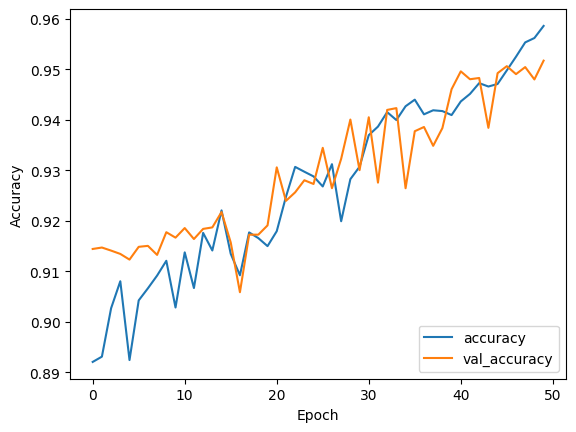

In [51]:
from tensorflow.keras.metrics import IoU

# Specify the target class IDs for which to calculate IoU
iou_metric = IoU(num_classes=2, target_class_ids=[0, 1]) # Add target_class_ids argument

model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss, metrics=['accuracy', iou_metric])
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    batch_size=16)

# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [52]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on the validation set
y_pred = model.predict(X_val)
y_pred_argmax = np.argmax(y_pred, axis=-1)
y_true_argmax = np.argmax(y_val, axis=-1)

# Flatten the predictions and ground truth
y_pred_flat = y_pred_argmax.flatten()
y_true_flat = y_true_argmax.flatten()

# Generate classification report
print(classification_report(y_true_flat, y_pred_flat, target_names=['Non-water', 'Water']))

# Compute IoU
intersection = np.logical_and(y_true_flat, y_pred_flat)
union = np.logical_or(y_true_flat, y_pred_flat)
iou_score = np.sum(intersection) / np.sum(union)
print(f'IoU Score: {iou_score}')


1/2 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepWARNING:tensorflow:6 out of the last 8 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000020551239A80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
              precision    recall  f1-score   support

   Non-water       0.96      0.98      0.97    787894
       Water       0.92      0.86      0.89    227914

    accuracy                           